# InceptionV3

## Installing & Importing Necessary Libraries

In [1]:
%pip install -q wandb

In [1]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import wandb
wandb.login()
import os
import pandas as pd
import matplotlib.pyplot as plt

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# Using W&B for better logging and visualizations
wandb.init(project="wound-classification-Inceptionv3", config={
    "learning_rate": 0.001,
    "architecture": "InceptionV3"
})

wandb: Currently logged in as: mrinoy-banerjee (aipi549). Use `wandb login --relogin` to force relogin


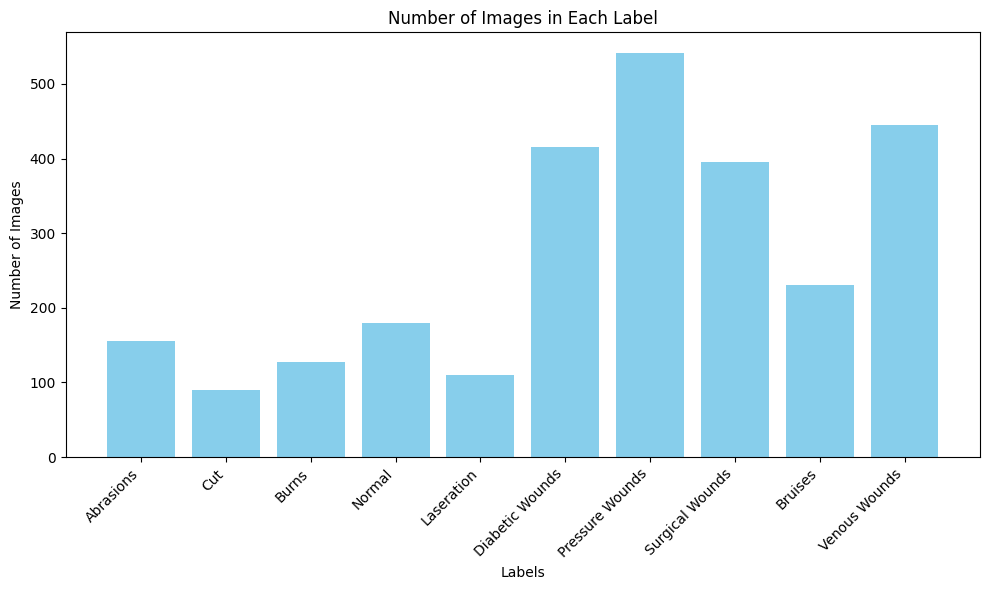

In [3]:
# Path to your dataset directory
data_dir = '/kaggle/input/wounddataset3/WoundDataset/train'

# List all the images in the dataset directory
labels = os.listdir(data_dir)

# Initialize a dictionary to store the count of images in each label
label_count = {}

# Count the number of images in each label
for label in labels:
    label_path = os.path.join(data_dir, label)
    num_images = len(os.listdir(label_path))
    label_count[label] = num_images

# Create a bar graph to visualize the count of images in each label
plt.figure(figsize=(10, 6))
plt.bar(label_count.keys(), label_count.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing

Data Transformations

In [5]:
def preprocess(data_dir):
    """
    Preprocesses images in the specified directory.

    Args:
    - data_dir (str): Path to the dataset directory.

    Returns:
    - dataset (torchvision.datasets.ImageFolder): Preprocessed dataset.
    """
    # Define transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ])

    # Create a dataset from the images in the specified directory
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    return dataset

## Modelling

Train & Validate functions

In [6]:
import torch
from tqdm import tqdm
import wandb  # Ensure wandb is installed or remove wandb logging if not using

def train_inceptionv3(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path):
    best_loss = float('inf')
    total_loss = []

    for epoch in range(epochs):
        print(f'Epoch [{epoch+1}/{epochs}]')
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}/{epochs}', unit='batch')

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Handle the auxiliary output
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Scaling the auxiliary loss as recommended

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / len(progress_bar), accuracy=100. * correct / total)

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct / total

        val_loss, val_accuracy = validate_inceptionv3(model, device, valloader, criterion)

        total_loss.append(train_loss)
        print(f'Validation Accuracy: {val_accuracy}')
        
        # Example of logging to W&B, comment out if you're not using W&B
        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_accuracy,
                   "val_loss": val_loss, "val_accuracy": val_accuracy})

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("Saving the model")

    print('Training finished!')
    return total_loss


def validate_inceptionv3(model, device, valloader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(valloader, desc='Validation', unit='batch')

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=val_loss / len(progress_bar), accuracy=100. * correct / total)

    val_loss /= len(valloader)
    val_accuracy = 100. * correct / total

    return val_loss, val_accuracy


In [7]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import torchvision.models as models
from torch import nn
import wandb  # Ensure wandb is installed or remove wandb logging if not using

# Assuming preprocess function and dataset are compatible with Inception v3 input requirements

# Record the starting time
start_time = time.time()

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to the dataset directory
data_dir = '/kaggle/input/wounddataset3/WoundDataset/train'

# Preprocess the dataset
dataset = preprocess(data_dir)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Number of epochs for training
epochs = 15

# Print the unique labels in the dataset
print(set(dataset.targets))

# Loop through folds for cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(dataset.imgs, dataset.targets)):
    print(f'Fold [{fold + 1}/5]')

    # Create train and validation datasets based on fold indices
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)

    # Create DataLoader for train and validation datasets
    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    # Initialize the model (Inception v3) with the appropriate number of output classes
    # Ensure to set transform_input=False if you have normalized the dataset manually
    model = models.inception_v3(pretrained=True, aux_logits=True, transform_input=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # Adjust the number of classes if different from 10

    # Move the model to the selected device
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize Weights & Biases for logging
    wandb.init(project="wound-classification-Inceptionv3", name=f"fold_{fold}")

    # Define the path to save the trained model
    model_path = f'/kaggle/working/inceptionv3_model_fold_{fold}.pth'

    # Train the model for the current fold
    # Ensure you are calling the modified training function compatible with Inception v3
    train_inceptionv3(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path)

# Record the ending time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Total time taken: {elapsed_time} seconds")


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Fold [1/5]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 143MB/s]  


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:07<00:00,  2.33batch/s, accuracy=39, loss=2.71]  


Validation Accuracy: 38.96103896103896
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.94batch/s, accuracy=62.9, loss=1.03] 


Validation Accuracy: 62.894248608534326
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.88batch/s, accuracy=64.9, loss=1.16] 


Validation Accuracy: 64.93506493506493
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.84batch/s, accuracy=67.9, loss=1]    


Validation Accuracy: 67.90352504638219
Saving the model
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.97batch/s, accuracy=73.1, loss=0.822]


Validation Accuracy: 73.09833024118738
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.03batch/s, accuracy=74.2, loss=0.853]


Validation Accuracy: 74.21150278293135
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.89batch/s, accuracy=78.1, loss=0.746]


Validation Accuracy: 78.10760667903526
Saving the model
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.82batch/s, accuracy=66.6, loss=1.02] 


Validation Accuracy: 66.6048237476809
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.90batch/s, accuracy=82.6, loss=0.479]


Validation Accuracy: 82.56029684601113
Saving the model
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.99batch/s, accuracy=75.7, loss=0.81] 


Validation Accuracy: 75.69573283858998
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.03batch/s, accuracy=85.3, loss=0.419]


Validation Accuracy: 85.34322820037106
Saving the model
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.86batch/s, accuracy=77.6, loss=0.782]


Validation Accuracy: 77.55102040816327
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.84batch/s, accuracy=81.4, loss=0.599]


Validation Accuracy: 81.44712430426716
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.02batch/s, accuracy=77.2, loss=0.883]


Validation Accuracy: 77.1799628942486
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.99batch/s, accuracy=85.7, loss=0.448]


Validation Accuracy: 85.71428571428571
Training finished!
Fold [2/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▆▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▅▅▆▆▇▅█▆█▇▇▇█
val_loss,█▃▃▃▂▂▂▃▁▂▁▂▂▂▁
epoch,15
train_accuracy,90.05576
train_loss,0.41481
val_accuracy,85.71429
val_loss,0.44784


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.91batch/s, accuracy=54.6, loss=1.32] 


Validation Accuracy: 54.646840148698885
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.88batch/s, accuracy=52, loss=1.45]   


Validation Accuracy: 52.04460966542751
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.81batch/s, accuracy=42.9, loss=2.04]


Validation Accuracy: 42.9368029739777
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.83batch/s, accuracy=73.4, loss=0.764]


Validation Accuracy: 73.42007434944237
Saving the model
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.75batch/s, accuracy=75.5, loss=0.743]


Validation Accuracy: 75.46468401486989
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.97batch/s, accuracy=78.3, loss=0.593]


Validation Accuracy: 78.25278810408922
Saving the model
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.84batch/s, accuracy=74.3, loss=0.823]


Validation Accuracy: 74.34944237918215
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.85batch/s, accuracy=76.4, loss=0.676]


Validation Accuracy: 76.39405204460967
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.90batch/s, accuracy=76.4, loss=0.847]


Validation Accuracy: 76.39405204460967
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.84batch/s, accuracy=74.3, loss=0.833]


Validation Accuracy: 74.34944237918215
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.92batch/s, accuracy=77.3, loss=0.741]


Validation Accuracy: 77.32342007434944
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.80batch/s, accuracy=78.4, loss=0.723]


Validation Accuracy: 78.43866171003718
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.95batch/s, accuracy=71.7, loss=0.965]


Validation Accuracy: 71.74721189591078
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.98batch/s, accuracy=83.8, loss=0.487]


Validation Accuracy: 83.82899628252788
Saving the model
Training finished!
Fold [3/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▃▃▁▆▇▇▆▇▇▆▇█▇▆█
val_loss,▅▅█▂▂▁▃▂▃▃▂▁▂▃▁
epoch,15
train_accuracy,89.41013
train_loss,0.43596
val_accuracy,83.829
val_loss,0.48694


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.91batch/s, accuracy=44.4, loss=1.86]


Validation Accuracy: 44.42379182156134
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.99batch/s, accuracy=64.7, loss=0.992]


Validation Accuracy: 64.68401486988847
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.05batch/s, accuracy=65.4, loss=1.01] 


Validation Accuracy: 65.4275092936803
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.10batch/s, accuracy=62.6, loss=1.14] 


Validation Accuracy: 62.639405204460964
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.03batch/s, accuracy=71, loss=0.772]  


Validation Accuracy: 71.00371747211896
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.12batch/s, accuracy=75.3, loss=0.792]


Validation Accuracy: 75.27881040892193
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.08batch/s, accuracy=74, loss=0.847]  


Validation Accuracy: 73.97769516728624
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.92batch/s, accuracy=77.9, loss=0.674]


Validation Accuracy: 77.88104089219331
Saving the model
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.01batch/s, accuracy=78.3, loss=0.622]


Validation Accuracy: 78.25278810408922
Saving the model
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.12batch/s, accuracy=83.5, loss=0.504]


Validation Accuracy: 83.45724907063197
Saving the model
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.03batch/s, accuracy=80.5, loss=0.655]


Validation Accuracy: 80.48327137546468
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.93batch/s, accuracy=82, loss=0.52]   


Validation Accuracy: 81.97026022304833
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.01batch/s, accuracy=85.7, loss=0.388]


Validation Accuracy: 85.68773234200744
Saving the model
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.08batch/s, accuracy=85.7, loss=0.47] 


Validation Accuracy: 85.68773234200744
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.01batch/s, accuracy=83.6, loss=0.578]


Validation Accuracy: 83.64312267657992
Training finished!
Fold [4/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇██
train_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▁▁
val_accuracy,▁▄▅▄▆▆▆▇▇█▇▇███
val_loss,█▄▄▅▃▃▃▂▂▂▂▂▁▁▂
epoch,15
train_accuracy,89.03855
train_loss,0.45364
val_accuracy,83.64312
val_loss,0.57816


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.92batch/s, accuracy=35.5, loss=2.02]


Validation Accuracy: 35.50185873605948
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.98batch/s, accuracy=48.1, loss=2.08]


Validation Accuracy: 48.141263940520446
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.96batch/s, accuracy=68.4, loss=1]    


Validation Accuracy: 68.40148698884758
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.07batch/s, accuracy=73.4, loss=0.76] 


Validation Accuracy: 73.42007434944237
Saving the model
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.01batch/s, accuracy=72.7, loss=0.769]


Validation Accuracy: 72.67657992565056
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.96batch/s, accuracy=69, loss=0.984]  


Validation Accuracy: 68.95910780669145
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.93batch/s, accuracy=76.6, loss=0.75] 


Validation Accuracy: 76.57992565055763
Saving the model
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.03batch/s, accuracy=82.5, loss=0.53] 


Validation Accuracy: 82.5278810408922
Saving the model
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.00batch/s, accuracy=80.1, loss=0.669]


Validation Accuracy: 80.11152416356877
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.96batch/s, accuracy=71.6, loss=1.05] 


Validation Accuracy: 71.56133828996282
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.96batch/s, accuracy=76.6, loss=0.693]


Validation Accuracy: 76.57992565055763
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.91batch/s, accuracy=78.3, loss=0.657]


Validation Accuracy: 78.25278810408922
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.81batch/s, accuracy=83.8, loss=0.491]


Validation Accuracy: 83.82899628252788
Saving the model
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.92batch/s, accuracy=82, loss=0.607]  


Validation Accuracy: 81.97026022304833
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.04batch/s, accuracy=82.2, loss=0.609]


Validation Accuracy: 82.15613382899629
Training finished!
Fold [5/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▆▆▇▇▇▇█▇██
train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▆▆▆▆▇█▇▆▇▇███
val_loss,██▃▂▂▃▂▁▂▃▂▂▁▂▂
epoch,15
train_accuracy,91.36089
train_loss,0.35273
val_accuracy,82.15613
val_loss,0.60901


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.75batch/s, accuracy=58.4, loss=1.52] 


Validation Accuracy: 58.36431226765799
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.90batch/s, accuracy=64.7, loss=1.02] 


Validation Accuracy: 64.68401486988847
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.88batch/s, accuracy=64.7, loss=0.946]


Validation Accuracy: 64.68401486988847
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.79batch/s, accuracy=69.3, loss=0.926]


Validation Accuracy: 69.33085501858736
Saving the model
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.86batch/s, accuracy=74, loss=0.694]  


Validation Accuracy: 73.97769516728624
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.88batch/s, accuracy=71.2, loss=1.02] 


Validation Accuracy: 71.18959107806691
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.73batch/s, accuracy=76.8, loss=0.673]


Validation Accuracy: 76.76579925650557
Saving the model
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.85batch/s, accuracy=79, loss=0.651]  


Validation Accuracy: 78.99628252788104
Saving the model
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.77batch/s, accuracy=73.2, loss=0.971]


Validation Accuracy: 73.23420074349443
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.80batch/s, accuracy=82.7, loss=0.586]


Validation Accuracy: 82.71375464684014
Saving the model
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.84batch/s, accuracy=83.8, loss=0.544]


Validation Accuracy: 83.82899628252788
Saving the model
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.74batch/s, accuracy=75.7, loss=1.09] 


Validation Accuracy: 75.65055762081785
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.94batch/s, accuracy=82.9, loss=0.548]


Validation Accuracy: 82.8996282527881
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.73batch/s, accuracy=82.9, loss=0.54] 


Validation Accuracy: 82.8996282527881
Saving the model
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.79batch/s, accuracy=81.2, loss=0.626]

Validation Accuracy: 81.22676579925651
Training finished!
Total time taken: 3454.6789643764496 seconds


## Plots

Train & Validation Accuracy; Train & Validation Loss is in W&B graphs

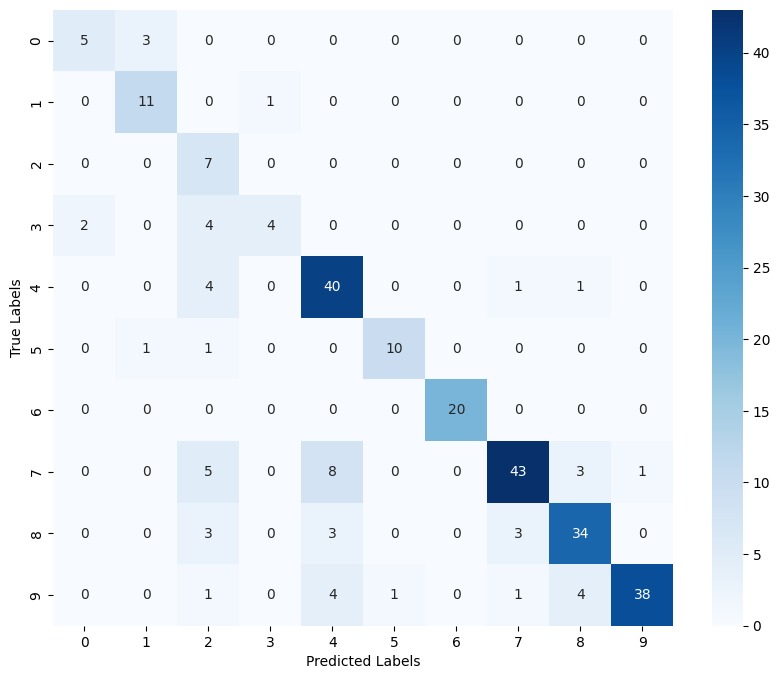

In [10]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

# Assuming device has been defined
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

best_model_path = '/kaggle/working/inceptionv3_model_fold_0.pth'

# Load the model without pretrained weights and disable auxiliary logits
model = models.inception_v3(pretrained=False, aux_logits=True)

# Load the saved state dict into the model
model.load_state_dict(torch.load(best_model_path, map_location=device))

model = model.to(device)
model.eval()

# Load and preprocess the test data
data_dir = '/kaggle/input/wounddataset3/WoundDataset/test'
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(data_dir, transform=transform)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Prediction and Evaluation
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # Ignore auxiliary outputs during inference
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_pred_y and y_test are your predicted and actual labels respectively

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute precision
precision = precision_score(y_true, y_pred, average='weighted')

# Compute recall
recall = recall_score(y_true, y_pred, average='weighted')

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7940074906367042
Precision: 0.8432248525506952
Recall: 0.7940074906367042
F1 Score: 0.8047690270166896
